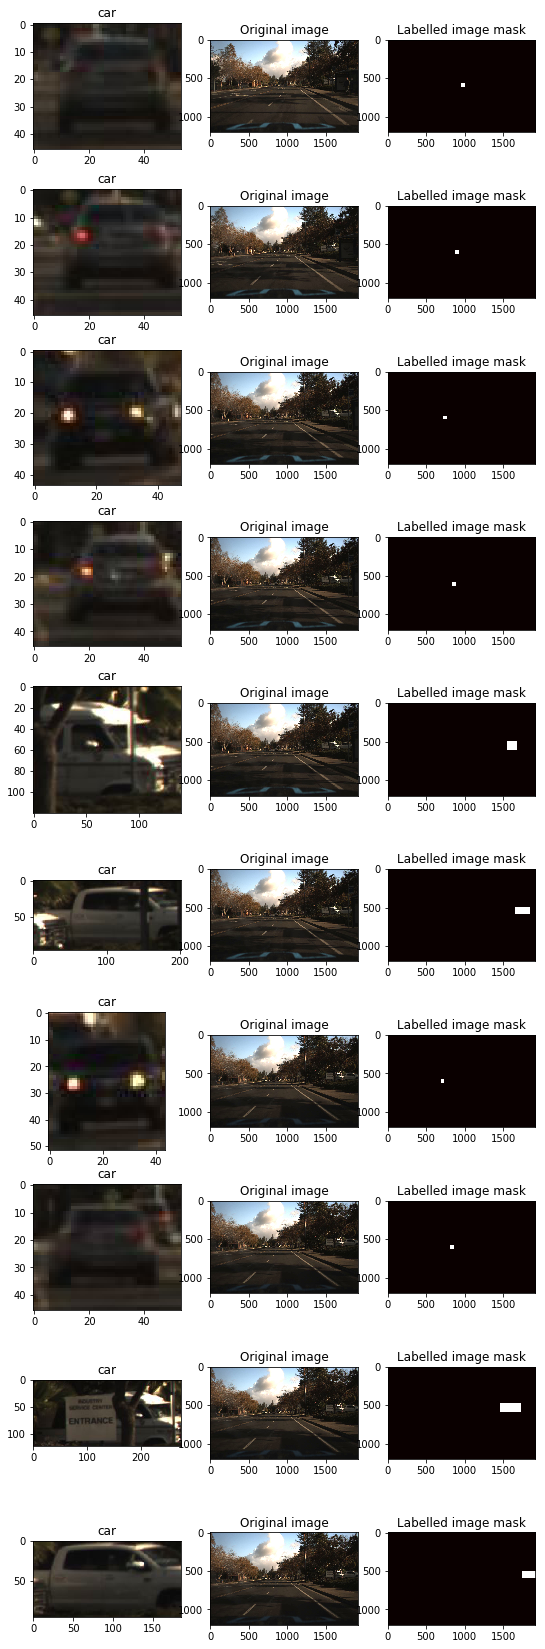

In [5]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import pandas as pd
import keras


IMG_SIZE = (320,480,3) # Original image is 1920 x 1200 x 3, we downscale by 4 to make it manageable
BBOX_SIZE = (64, 64)
NUM_TO_SHOW = 10
LABEL_MAP = {
    "car": 1,
    "truck": 2,
    "pedestrian": 3,
    "trafficLight": 4,
    "biker": 5,
    "others": 0 # background pixels
}

df = pd.read_csv("./object-dataset/labels.csv", sep=" ")
df = df[df["label"] == "car"]
fig, axes = plt.subplots(NUM_TO_SHOW, 3, figsize=(9, NUM_TO_SHOW * 3))
# Visualize dataset
count = 0
for index, row in df.iterrows():
    if count < NUM_TO_SHOW and row["label"] == "car":
        img = mpimg.imread("./object-dataset/" + row["frame"])
        xmin = row["xmin"]
        xmax = row["xmax"]
        ymin = row["ymin"]
        ymax = row["ymax"]
        axes[count,0].imshow(img[ymin:ymax, xmin:xmax])
        axes[count,0].set_title(row["label"])
        
        axes[count,1].imshow(img)
        axes[count,1].set_title("Original image")
        
        # build up dataset
        class_ = LABEL_MAP[row["label"]]
        label = np.zeros((img.shape[0], img.shape[1]))
        label[ymin:ymax, xmin:xmax] = class_
        axes[count,2].imshow(label*10, cmap='hot')
        axes[count,2].set_title("Labelled image mask")
        count += 1
    else:
        break

    

In [7]:
import time

FRACTION_TO_TEST = 0.8
msk = np.random.rand(len(df)) < FRACTION_TO_TEST

train = df[msk]
test = df[~msk]

print("Splitting into train and validation sets")
print(test.shape)
print(train.shape)

Splitting into train and validation sets
(12254, 8)
(48534, 8)


In [8]:
from keras.utils import Sequence

class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, df, batch_size=32, dim=(32,32), n_channels=1,
                 n_classes=10, shuffle=True):
        'Initialization'
        self.df = df
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = len(df)
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(self.list_IDs)/ self.batch_size)

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, y = self.__data_generation(indexes)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.list_IDs)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim, 1), dtype=int)
        
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            img = mpimg.imread("./object-dataset/" + self.df.iloc[ID]["frame"])
            # Store sample
            X[i,] = cv2.resize(img, (IMG_SIZE[1], IMG_SIZE[0]))

            # Store class
            row = self.df.iloc[ID]
            xmin = row["xmin"]
            xmax = row["xmax"]
            ymin = row["ymin"]
            ymax = row["ymax"]
            class_ = 1
            label = np.zeros((img.shape[0], img.shape[1]))
            label[ymin:ymax, xmin:xmax] = class_
            label = cv2.resize(label, (IMG_SIZE[1], IMG_SIZE[0]))
            y[i] = np.reshape(label, (label.shape[0], label.shape[1], 1))

        return X, y

In [9]:
import os 
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import numpy as np
from keras.models import *
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Cropping2D
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

class Unet(object):

    def __init__(self, train, test, img_rows = 512, img_cols = 512):
        self.training_generator = train
        self.validation_generator = test
        self.img_rows = img_rows
        self.img_cols = img_cols

    def load_data(self):
        pass

    def get_unet(self):

        inputs = Input((self.img_rows, self.img_cols, 3))

        conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
        print("conv1 shape:",conv1.get_shape())
        conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
        print("conv1 shape:",conv1.get_shape())
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
        print("pool1 shape:",pool1.get_shape())

        conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
        print("conv2 shape:",conv2.get_shape())
        conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
        print("conv2 shape:",conv2.get_shape())
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
        print("pool2 shape:",pool2.get_shape())

        conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
        print("conv3 shape:",conv3.get_shape())
        conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
        print("conv3 shape:",conv3.get_shape())
        pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
        print("pool3 shape:",pool3.get_shape())

        conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
        conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
        print("conv4 shape:",conv4.get_shape())
        drop4 = Dropout(0.5)(conv4)
        pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
        print("pool4 shape:",pool4.get_shape())
        print("drop4 shape:",drop4.get_shape())

        conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
        conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
        print("conv5 shape:",conv5.get_shape())
        drop5 = Dropout(0.5)(conv5)

        up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
        print("up6 shape:",up6.get_shape())
        merge6 = concatenate([drop4,up6], axis = 3)
        print("merge6 shape:", merge6.get_shape())
        conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
        conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
        print("conv6 shape:",conv6.get_shape())
        
        up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
        print("up7 shape:", up7.get_shape())
        merge7 = concatenate([conv3,up7], axis = 3)
        conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
        conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

        up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
        merge8 = concatenate([conv2,up8], axis = 3)
        conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
        conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

        up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
        merge9 = concatenate([conv1,up9], axis = 3)
        conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
        conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
        conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
        conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

        model = Model(inputs = inputs, outputs = conv10)

        model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

        return model


    def train(self):
        # print("loading data")
        # imgs_train, imgs_mask_train, imgs_test = self.load_data()
        # print("loading data done")
        self.model = self.get_unet()
        print("got unet")

        model_checkpoint = ModelCheckpoint('unet.hdf5', monitor='loss',verbose=1, save_best_only=True)
        print('Fitting model...')
        self.model.fit_generator(generator=self.training_generator,
                            validation_data=self.validation_generator,
                            use_multiprocessing=True,
                            workers=6, epochs=1, verbose=1, steps_per_epoch=steps_per_epoch,
                            callbacks=[model_checkpoint])
        

    def save_img(self):

        print("array to image")
        imgs = np.load('imgs_mask_test.npy')
        for i in range(imgs.shape[0]):
            img = imgs[i]
            img = array_to_img(img)
            img.save("../results/%d.jpg"%(i))


# Parameters
params = {'dim': (IMG_SIZE[0], IMG_SIZE[1]),
          'batch_size': 8,
          'n_classes': 1,
          'n_channels': 3,
          'shuffle': True}
steps_per_epoch = int(len(train)//params['batch_size'])
training_generator = DataGenerator(train, **params)
validation_generator = DataGenerator(test, **params)
model = Unet(training_generator, validation_generator, IMG_SIZE[0], IMG_SIZE[1])
model.train()

conv1 shape: (?, 320, 480, 64)
conv1 shape: (?, 320, 480, 64)
pool1 shape: (?, 160, 240, 64)
conv2 shape: (?, 160, 240, 128)
conv2 shape: (?, 160, 240, 128)
pool2 shape: (?, 80, 120, 128)
conv3 shape: (?, 80, 120, 256)
conv3 shape: (?, 80, 120, 256)
pool3 shape: (?, 40, 60, 256)
conv4 shape: (?, 40, 60, 512)
pool4 shape: (?, 20, 30, 512)
drop4 shape: (?, 40, 60, 512)
conv5 shape: (?, 20, 30, 1024)
up6 shape: (?, 40, 60, 512)
merge6 shape: (?, 40, 60, 1024)
conv6 shape: (?, 40, 60, 512)
up7 shape: (?, 80, 120, 256)
got unet
Fitting model...
Epoch 1/1
3758/6066 [=================>............] - ETA: 20:14 - loss: 0.2391 - acc: 0.9851

Process ForkPoolWorker-4:
Process ForkPoolWorker-5:
Process ForkPoolWorker-6:
Process ForkPoolWorker-3:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/mul

KeyboardInterrupt: 